<h1><center>Welcome to the World of Cinema!</center></h1>

*“In times of crisis, we turn to the arts…”*

The whole lockdown scenario following COVID-19 has been a period of high levels of stress for me. The books that I read, the music I heard and the movies I watched helped me to a very large extent to ease the stress. This period also gave me the much-needed impetus to delve deeper into the world of cinema to try to understand any underlying patterns that existed. Consider this my voyage into this vast expanse of a field, Cinema.

As a child, my amazement for the world of Cinema has only grown manifold with every film I watched. I have lapped up every movie irrespective of the language or genre with the same enthusiasm of a kid at a candy shop. Here, from one movie lover to another, I would like to create a recommendation engine that would help you to find new movies and expand your horizons.

As Roger Ebert says, *“One of the gifts a movie lover can give another is the title of a wonderful film they have not yet discovered.”*


![title](img/Spielberg.jpg)

## Dataset 

[**Full MovieLens Dataset**](https://www.kaggle.com/rounakbanik/the-movies-dataset)

- Consists of movies released on or before July 2017. Data points include cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, TMDB vote counts and vote averages.


- Also has files containing 100,000 ratings from 700 users for a small subset of 9,000 movies. Ratings are on a scale of 1-5 and have been obtained from the official GroupLens website.


## Loading the data

In [158]:
%matplotlib inline

import pandas as pd                            # To store the data

import numpy as np                             # For Linear Algebra

import matplotlib.pyplot as plt                # Creating plots

import seaborn as sns

import numpy as np

import surprise as sp

import datetime

import ast

import warnings

warnings.filterwarnings('ignore')

from plotly.offline import init_notebook_mode, plot, iplot # To create interactive plots

import plotly.graph_objs as go

init_notebook_mode(connected=True)

from sklearn.metrics import mean_squared_error

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

from sklearn.dummy import DummyClassifier, DummyRegressor

from sklearn.model_selection import train_test_split

from math import sqrt
  
from scipy import stats

from ast import literal_eval

from xgboost import XGBClassifier, XGBRegressor

from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

from nltk.stem.snowball import SnowballStemmer

from nltk.stem.wordnet import WordNetLemmatizer

from nltk.corpus import wordnet

from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout

from keras.models import Model

from scipy.sparse import coo_matrix

from lightfm import LightFM

from lightfm.evaluation import precision_at_k

from scipy.sparse import vstack

In [159]:
df = pd.read_csv('D:/Cinci prep/Coursework/Python/the-movies-dataset/movies_metadata.csv')
ratings = pd.read_csv('D:/Cinci prep/Coursework/Python/the-movies-dataset/ratings_small.csv')
links_small = pd.read_csv('D:/Cinci prep/Coursework/Python/the-movies-dataset/links_small.csv')
credits = pd.read_csv('D:/Cinci prep/Coursework/Python/the-movies-dataset/credits.csv')
keywords = pd.read_csv('D:/Cinci prep/Coursework/Python/the-movies-dataset/keywords.csv')

In [160]:
print("The movies dataset has      {} rows and {} columns".format(df.shape[0],df.shape[1]))
print("The ratings dataset has     {} rows and {} columns".format(ratings.shape[0],ratings.shape[1]))
print("The links_small dataset has {} rows and {} columns".format(links_small.shape[0],links_small.shape[1]))
print("The credits dataset has     {} rows and {} columns".format(credits.shape[0],credits.shape[1]))
print("The keywords dataset has    {} rows and {} columns".format(keywords.shape[0],keywords.shape[1]))

The movies dataset has      45466 rows and 24 columns
The ratings dataset has     100004 rows and 4 columns
The links_small dataset has 9125 rows and 3 columns
The credits dataset has     45476 rows and 3 columns
The keywords dataset has    46419 rows and 2 columns


#### Description of the Meta_Movies  (df) dataset

| Column Name | Description |
| :- | :- |
| adult | Indicates if the movie is X-Rated or Adult. |
| belongs_to_collection | Information on the movie series the particular film belongs to |
| budget | The budget of the movie in dollars. |
|genres: | genres associated with the movie |
| homepage | The Official Homepage of the move |
|id |: The ID of the move. |
| imdb_id |  The IMDB ID of the movie. |
| original_language |  The language in which the movie was originally shot in. |
| original_title |  The original title of the movie. |
| overview |  A brief blurb of the movie. |
| popularity |  The Popularity Score assigned by TMDB. |
| poster_path |  The URL of the poster image. |
| production_companies |  List of Production companies involved in making of the movie |
| production_countries |  List of countries where the movie was shot/produced in. |
| release_date |  Theatrical Release Date of the movie. |
| revenue |  The total revenue of the movie in dollars. |
| runtime |  The runtime of the movie in minutes. |
| spoken_languages |  A stringified list of spoken languages in the film. |
| status |  The status of the movie (Released, To Be Released, Announced, etc.) |
| tagline |  The tagline of the movie. |
| title | The Official Title of the movie. |
| video | Indicates if there is a video present of the movie with TMDB. |
| vote_average | The average rating of the movie. |
| vote_count | The number of votes by users, as counted by TMDB. |

#### Description of the Credits dataset

| Column Name | Description |
| :- | :- |
| cast | A stringified list of dictionaries that list out all the cast members associated with the movie. |
| crew | A stringified list of dictionaries that list out all the crew members associated with the movie. |
|id | The ID of the move. |

# DATA WRANGLING

## Meta_movies dataset

In [161]:
def missing_values(df):
    total_na = df.isnull().sum()
    percent = round((df.isnull().sum()/df.isnull().count()*100),2)
    output =  pd.concat([total_na, percent], axis=1, keys=['Total', 'Percent (%)'])
    return output[output['Percent (%)']>0].sort_values(by = ['Percent (%)'],ascending = False)

missing_values(df)

,Total,Percent (%)
belongs_to_collection,40972,90.12
homepage,37684,82.88
tagline,25054,55.10
overview,954,2.10
poster_path,386,0.85
runtime,263,0.58
status,87,0.19
release_date,87,0.19
imdb_id,17,0.04
original_language,11,0.02


In [162]:
df['adult'].value_counts()

False                                                                                                                             45454
True                                                                                                                                  9
 Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.                        1
 - Written by Ørnås                                                                                                                   1
 Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.        1
Name: adult, dtype: int64

In [163]:
df = df[df['title'].notna()] # Removing rows having no movie title name

# Removing irrelevant columns
df = df.drop('imdb_id', axis=1) 
df = df.drop('original_title', axis=1) # Original titles have titles of the movie in their regional languages. Hence, removing
df = df.drop('adult', axis=1) # 99% of the values are FALSE. Hence, not relevant 

In [164]:
df['poster_path'] = "<img src='" + 'http://image.tmdb.org/t/p/w185/' + df['poster_path'] + "' style='height:100px;'>"

In order to do an analysis on the time period in which these movies were created, we create a column called **year** which will have the year of the release

In [165]:
df['year'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

The budget feature has some unclean values that makes Pandas assign it as a generic object. We proceed to convert this into a numeric variable and replace all the non-numeric values with NaN. Finally, as with budget, we will convert all the values of 0 with NaN to indicate the absence of information regarding budget.

In [166]:
df['revenue'] = df['revenue'].replace(0, np.nan)
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df['budget'] = df['budget'].replace(0, np.nan)

It would be best to convert the revenue and the budget associated with the movies into Millions for ease of understanding. In this context, we also create **Returns per $ spent** to understand the profitable movie outings.

Profitable ventures will have a return of more than 1 per dollar spent

In [167]:
df['Revenue (in Millions)'] = round(df['revenue'] / 1000000,2)
df['Budget (in Millions)'] = round(df['budget'] / 1000000,2)
df['Returns per $ spent'] = df['Revenue (in Millions)'] / df['Budget (in Millions)']

We proceed to clean the popularity, vote_count and vote_average columns as well

In [168]:
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

In [169]:
df['popularity'] = df['popularity'].apply(clean_numeric).astype('float')
df['vote_count'] = df['vote_count'].apply(clean_numeric).astype('float')
df['vote_average'] = df['vote_average'].apply(clean_numeric).astype('float')

In [170]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [173]:
df['id'] = df['id'].apply(convert_int)
df['id'] = df['id'].astype('int')

In [246]:
md = df.copy()

## Credits dataset

In [140]:
missing_values(credits)

,Total,Percent (%)


The credit dataset doesn't have any null values and the data looks relatively clean upon initial exploration

## Merged Dataset (Merging meta_moviedata and credits)

In [175]:
merged_data = df.merge(credits_df, on='id')
merged_data.shape

(45535, 27)

In [176]:
merged_data['cast'] = merged_data['cast'].apply(ast.literal_eval)
merged_data['crew'] = merged_data['crew'].apply(ast.literal_eval)

In [177]:
merged_data['cast_size'] = merged_data['cast'].apply(lambda x: len(x))
merged_data['crew_size'] = merged_data['crew'].apply(lambda x: len(x))

In [178]:
merged_data['cast'] = merged_data['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [179]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [180]:
merged_data['director'] = merged_data['crew'].apply(get_director)

In [181]:
s = merged_data.apply(lambda x: pd.Series(x['cast']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'actor'
cast_df = merged_data.drop('cast', axis=1).join(s)

# Let's take a plunge into the World of Cinema 

## Numbers game : The economics of the movie business 

The glamour associated with movies comes mainly from the money they rake in at the box office. we would be looking at just that in the initial stages of exploration:

#### Highest grossing individual movies

The top 5 grossing movies of all time are as follows (this data is only mor movies released till July 2017). These figures have not been adjusted for inflation. 

In [141]:
from IPython.display import Image, HTML

In [146]:
#highest grossing individual movies
gross_top = df[['poster_path', 'title','year', 'Budget (in Millions)', 'Revenue (in Millions)','Returns per $ spent']].sort_values('Revenue (in Millions)', ascending=False).head(10)
pd.set_option('display.max_colwidth', 500)
HTML(gross_top.to_html(escape=False))

,poster_path,title,year,Budget (in Millions),Revenue (in Millions),Returns per $ spent
14551,,Avatar,2009,237.0,2787.97,11.763586
26555,,Star Wars: The Force Awakens,2015,245.0,2068.22,8.441714
1639,,Titanic,1997,200.0,1845.03,9.225150
17818,,The Avengers,2012,220.0,1519.56,6.907091
25084,,Jurassic World,2015,150.0,1513.53,10.090200
28830,,Furious 7,2015,190.0,1506.25,7.927632
26558,,Avengers: Age of Ultron,2015,280.0,1405.40,5.019286
17437,,Harry Potter and the Deathly Hallows: Part 2,2011,125.0,1342.00,10.736000
22110,,Frozen,2013,150.0,1274.22,8.494800
42222,,Beauty and the Beast,2017,160.0,1262.89,7.893063


#### Highest grossing franchises
We consider those movies that belong to a collection. Minimum of 2 movies in a collection

In [143]:
df_fran = df[df['belongs_to_collection'].notnull()]
df_fran['belongs_to_collection'] = df_fran['belongs_to_collection'].apply(ast.literal_eval).apply(lambda x: x['name'] if isinstance(x, dict) else np.nan)
df_fran = df_fran[df_fran['belongs_to_collection'].notnull()]

In [144]:
franchise_colln = df_fran.groupby('belongs_to_collection')['Revenue (in Millions)'].agg(No_of_movies='count', Avg_revenue_per_movie = 'mean',Gross_revenue='sum').sort_values('Gross_revenue', ascending=False).head(10)
franchise_colln

,No_of_movies,Avg_revenue_per_movie,Gross_revenue
belongs_to_collection,,,
Harry Potter Collection,8,963.421250,7707.37
Star Wars Collection,8,929.312500,7434.50
James Bond Collection,26,273.344615,7106.96
The Fast and the Furious Collection,8,640.636250,5125.09
Pirates of the Caribbean Collection,5,904.314000,4521.57
Transformers Collection,5,873.222000,4366.11
Despicable Me Collection,4,922.765000,3691.06
The Twilight Collection,5,668.422000,3342.11
Ice Age Collection,5,643.342000,3216.71


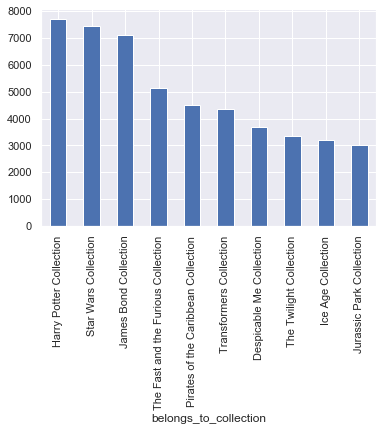

In [145]:
franchise_colln['Gross_revenue'].plot.bar();

#### The big players

In light of the highest grossing films and franchises given above, we would only be curious to see who goes home with the money

**Biggest production houses** 

In [147]:
df['production_companies'] = df['production_companies'].fillna('[]').apply(ast.literal_eval)
df['production_companies'] = df['production_companies'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [148]:
s = df.apply(lambda x: pd.Series(x['production_companies']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'companies'
com_df = df.drop('production_companies', axis=1).join(s)

In [149]:
com_sum = pd.DataFrame(com_df.groupby('companies')['Revenue (in Millions)'].sum().sort_values(ascending=False))
com_sum.columns = ['Total_Revenue (in Millions)']
com_mean = pd.DataFrame(com_df.groupby('companies')['Revenue (in Millions)'].mean().sort_values(ascending=False))
com_mean.columns = ['Average_revenue_per_film (in Millions)']
com_count = pd.DataFrame(com_df.groupby('companies')['Revenue (in Millions)'].count().sort_values(ascending=False))
com_count.columns = ['Number of films produced']

com_pivot = pd.concat((com_sum, com_mean, com_count), axis=1)

In [150]:
com_pivot.sort_values('Total_Revenue (in Millions)', ascending=False).head(10)

,Total_Revenue (in Millions),Average_revenue_per_film (in Millions),Number of films produced
Warner Bros.,63525.28,129.379389,491
Universal Pictures,55259.15,119.350216,463
Paramount Pictures,48808.15,123.564937,395
Twentieth Century Fox Film Corporation,47687.58,139.846276,341
Walt Disney Pictures,40837.22,277.804218,147
Columbia Pictures,32279.79,136.778771,236
New Line Cinema,22173.44,111.987071,198
Amblin Entertainment,17343.73,255.054853,68
DreamWorks SKG,15475.72,198.406667,78
Dune Entertainment,15003.78,241.996452,62


**Actors with the biggest revenue** 

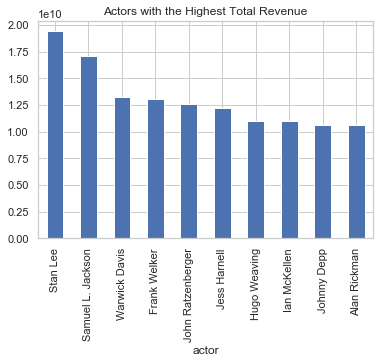

In [182]:
sns.set_style('whitegrid')
plt.title('Actors with the Highest Total Revenue')
cast_df.groupby('actor')['revenue'].sum().sort_values(ascending=False).head(10).plot(kind='bar')
plt.show()

**Directors with the biggest revenue** 

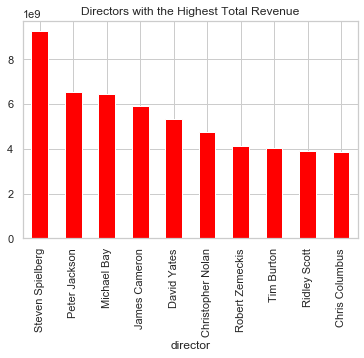

In [184]:
plt.title('Directors with the Highest Total Revenue')
merged_data.groupby('director')['revenue'].sum().sort_values(ascending=False).head(10).plot(kind='bar', colormap='autumn')
plt.show()

## Movie Recommendations : Explore new cinema!

Before moving on to create recommendation systems that cater to your interest, let us see what the popular genre is.

### Popular Genre

In [185]:
df['genres'] = df['genres'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [186]:
s = df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'

In [187]:
gen_df = df.drop('genres', axis=1).join(s)
gen_df['genre'].value_counts().shape[0]

20

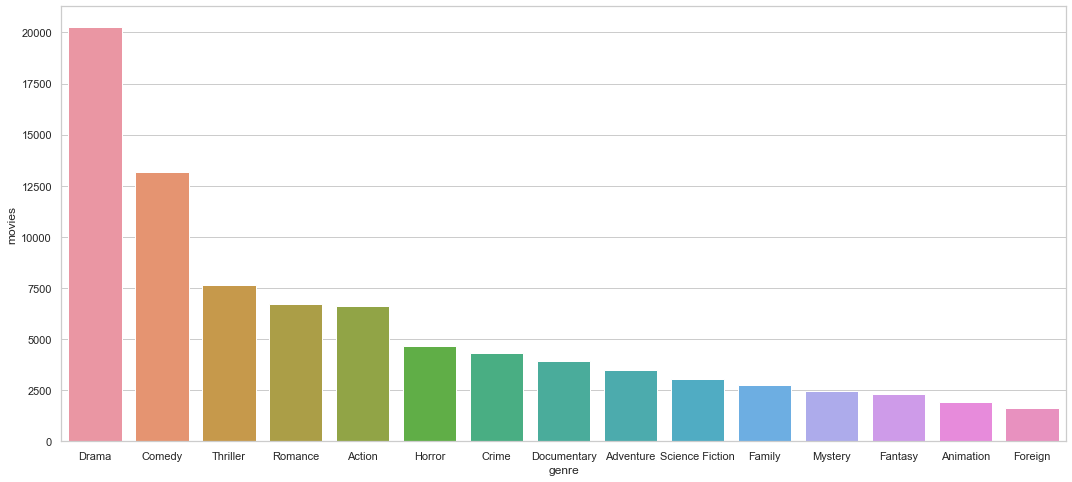

In [188]:
pop_gen = pd.DataFrame(gen_df['genre'].value_counts()).reset_index()
pop_gen.columns = ['genre', 'movies']
plt.figure(figsize=(18,8))
sns.barplot(x='genre', y='movies', data=pop_gen.head(15))
plt.show()

## Popular Words in Titles

Is there any popular word in the movie titles across the word? Let's find out

In [190]:
df['title'] = df['title'].astype('str')
df['overview'] = df['overview'].astype('str')
title_corpus = ' '.join(df['title'])
overview_corpus = ' '.join(df['overview'])

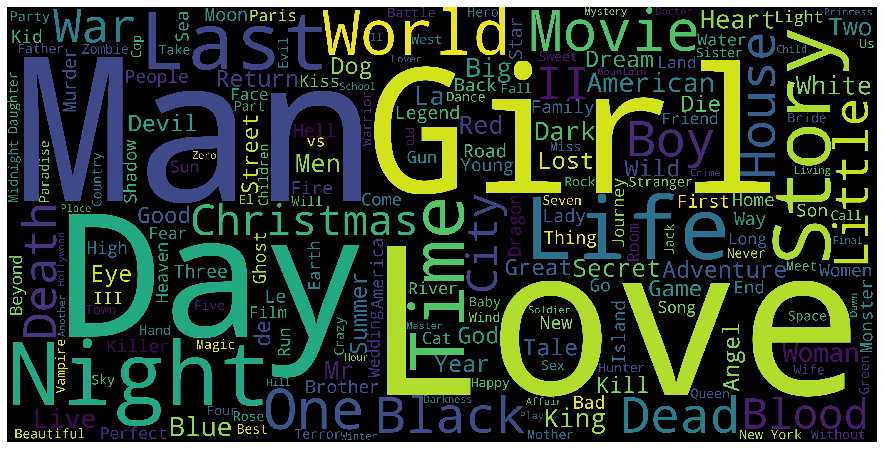

In [192]:
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

## Popular Words in the movie description

Onto the popular words in the overview

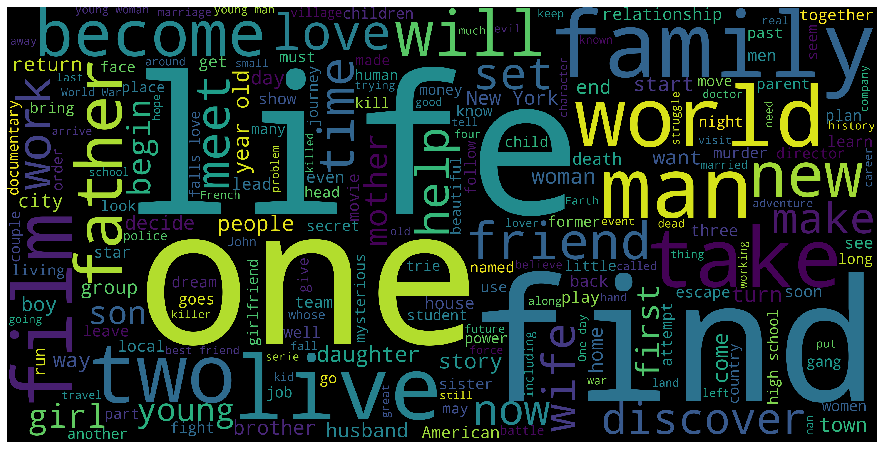

In [193]:
overview_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(overview_corpus)
plt.figure(figsize=(16,8))
plt.imshow(overview_wordcloud)
plt.axis('off')
plt.show()

**Reshaping data**

In [198]:
vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
m = vote_counts.quantile(0.80) #50
c = ratings['movieId'].value_counts().quantile(0.90) # 28

In [199]:
# Remove the long tail of rarly rated moves
movie_metadata = df[['title', 'overview', 'vote_count']].set_index('title').dropna()
movie_metadata = movie_metadata[movie_metadata['vote_count']>m].drop('vote_count', axis=1)

print('Shape Movie-Metadata:\t{}'.format(movie_metadata.shape))

Shape Movie-Metadata:	(9048, 1)


In [200]:
# Filter sparse movies
filter_movies = (ratings['movieId'].value_counts()>c)
filter_movies = filter_movies[filter_movies].index.tolist()

# Actual filtering
df_filterd = ratings[ratings['movieId'].isin(filter_movies)]
print('Shape User-Ratings unfiltered:\t{}'.format(ratings.shape))
print('Shape User-Ratings filtered:\t{}'.format(df_filterd.shape))

Shape User-Ratings unfiltered:	(100004, 4)
Shape User-Ratings filtered:	(59260, 4)


In [201]:
# Shuffle DataFrame
df_filterd = df_filterd.drop('timestamp', axis=1).sample(frac=1).reset_index(drop=True)

# Testingsize
n = int(len(df_filterd)*0.8)

# Split train- & testset
df_train = df_filterd[:-n]
df_test = df_filterd[-n:]

In [217]:
# Create a user-movie matrix with empty values
df_p = df_train.pivot_table(index='userId', columns='movieId', values='rating')
print('Shape User-Movie-Matrix:\t{}'.format(df_p.shape))
df_p.sample(3)

Shape User-Movie-Matrix:	(669, 883)


movieId,1,2,3,5,6,7,10,11,14,16,...,91529,99114,104841,106782,109374,109487,112852,116797,122882,122886
userId,,,,,,,,,,,,,,,,,,,,,
573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Simple Recommender 
### Weighted Mean Rating

Taking a mean rating for all movies will create a ranking. However, approach is biased and favours movies with fewer ratings, since large numbers of ratings tend to be less extreme in its mean ratings.To tackle the problem of the unstable mean with few ratings e.g. IDMb uses a weighted rating. Many good ratings outweigh few in this algorithm.

In [248]:
qualified = md[(md['vote_count'] >= m) & (md['vote_count'].notnull()) & (md['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(9151, 6)

In [249]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [250]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [251]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

In [252]:
s = md.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = md.drop('genres', axis=1).join(s)

def build_chart(genre, percentile=0.85):
    df = gen_md[gen_md['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

build_chart('Action').head(15)

,title,year,vote_count,vote_average,popularity,wr
15480,Inception,2010,14075,8,29.108149,7.955099
12481,The Dark Knight,2008,12269,8,123.167259,7.948610
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,7.929579
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,7.924031
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,7.918382
256,Star Wars,1977,6778,8,42.149697,7.908327
1154,The Empire Strikes Back,1980,5998,8,19.470959,7.896841
4135,Scarface,1983,3017,8,11.299673,7.802046
9430,Oldboy,2003,2000,8,10.616859,7.711649
1910,Seven Samurai,1954,892,8,15.017770,7.426145


## Cosine similarity based recommendations

In the absence of historical data, it would be useful to compare the metadata of the movies to find similar ones.
Here, we use the movie description to create a TFIDF-matrix, which counts and weights words in all descriptions, and compute a cosine similarity between all of those sparse text-vectors.

The caveat in this case is that there is no way for this model to compute a RMSE score, since the model does not recommend the movies directly. Also, though this method makes it easier to find movies closly related to each other, but it is hard to find movies of different genres/categories.

In [204]:
# Create tf-idf matrix for text comparison
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movie_metadata['overview'].dropna())

In [205]:
# Compute cosine similarity between all movie-descriptions
similarity = linear_kernel(tfidf_matrix, tfidf_matrix)
#similarity = cosine_similarity(tfidf_matrix)
# Remove self-similarity from matrix
similarity -= np.eye(similarity.shape[0])

In [216]:
# Get index of movie to find similar movies
movie = 'Batman Begins'
n_plot = 10
index = movie_metadata.reset_index(drop=True)[movie_metadata.index==movie].index[0]

# Get indices and scores of similar movies
similar_movies_index = np.argsort(similarity[index])[::-1][:n_plot]
similar_movies_score = np.sort(similarity[index])[::-1][:n_plot]

# Get titles of similar movies
similar_movie_titles = movie_metadata.iloc[similar_movies_index].index


# Create trace
trace = go.Bar(x = similar_movies_score,
               text = similar_movie_titles,
               textposition = 'inside',
               textfont = dict(color = '#000000'),
               orientation = 'h',
               y = list(range(1, n_plot+1)),
               marker = dict(color = '#db0000'))
# Create layout
layout = dict(title = 'Ranking Of Top {} Most Similar Movie Descriptions For "{}"'.format(n_plot, movie),
              xaxis = dict(title = 'Cosine TFIDF Description Similarity',
                           range = (0, 0.4)),
              yaxis = dict(title = 'Movie'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

## Matrix Factorisation With Keras And Gradient Descent

Using matrix factorisation a large matrix can be estimated/decomposed into two long but slim matrices. With gradient descent it is possible to adjust these matrices to represent the given ratings. The gradient descent algorithm finds latent variables which represent the underlying structure of the dataset. Afterwards these latent variables can be used to reconstruct the original matrix and to predict the missing ratings for each user.

In this case the model has not been trained to convergence and is not hyperparameter optimized.

In [232]:
# Create user- & movie-id mapping
user_id_mapping = {id:i for i, id in enumerate(df_filterd['userId'].unique())}
movie_id_mapping = {id:i for i, id in enumerate(df_filterd['movieId'].unique())}

In [233]:
# Create correctly mapped train- & testset
train_user_data = df_train['userId'].map(user_id_mapping)
train_movie_data = df_train['movieId'].map(movie_id_mapping)

test_user_data = df_test['userId'].map(user_id_mapping)
test_movie_data = df_test['movieId'].map(movie_id_mapping)


In [234]:
# Get input variable-sizes
users = len(user_id_mapping)
movies = len(movie_id_mapping)
embedding_size = 10

In [235]:

##### Create model
# Set input layers
user_id_input = Input(shape=[1], name='user')
movie_id_input = Input(shape=[1], name='movie')

In [236]:
# Create embedding layers for users and movies
user_embedding = Embedding(output_dim=embedding_size, 
                           input_dim=users,
                           input_length=1, 
                           name='user_embedding')(user_id_input)
movie_embedding = Embedding(output_dim=embedding_size, 
                            input_dim=movies,
                            input_length=1, 
                            name='item_embedding')(movie_id_input)

In [237]:

# Reshape the embedding layers
user_vector = Reshape([embedding_size])(user_embedding)
movie_vector = Reshape([embedding_size])(movie_embedding)


In [238]:

# Compute dot-product of reshaped embedding layers as prediction
y = Dot(1, normalize=False)([user_vector, movie_vector])

# Setup model
model = Model(inputs=[user_id_input, movie_id_input], outputs=y)
model.compile(loss='mse', optimizer='adam')

In [239]:
# Fit model
model.fit([train_user_data, train_movie_data],
          df_train['rating'],
          batch_size=256, 
          epochs=1,
          validation_split=0.1,
          shuffle=True)


Train on 10666 samples, validate on 1186 samples
Epoch 1/1
10666/10666 [==============================] - 0s 10us/step - loss: 14.6052 - val_loss: 14.4365


In [240]:

# Test model
y_pred = model.predict([test_user_data, test_movie_data])
y_true = df_test['rating'].values

#  Compute RMSE
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
print('\n\nTesting Result With Keras Matrix-Factorization: {:.4f} RMSE'.format(rmse))



Testing Result With Keras Matrix-Factorization: 3.8164 RMSE


## Deep Learning With Keras

With its embedding layers this is similar to the matrix factorization approach above, but instead of using a fixed dot-product as recommendation we will utilize some dense layers so the network can find better combinations.

In [107]:
# Setup variables
user_embedding_size = 20
movie_embedding_size = 10

In [108]:

##### Create model
# Set input layers
user_id_input = Input(shape=[1], name='user')
movie_id_input = Input(shape=[1], name='movie')

In [112]:

# Create embedding layers for users and movies
user_embedding = Embedding(output_dim=user_embedding_size, 
                           input_dim=users,
                           input_length=1, 
                           name='user_embedding')(user_id_input)
movie_embedding = Embedding(output_dim=movie_embedding_size, 
                            input_dim=movies,
                            input_length=1, 
                            name='item_embedding')(movie_id_input)

# Reshape the embedding layers
user_vector = Reshape([user_embedding_size])(user_embedding)
movie_vector = Reshape([movie_embedding_size])(movie_embedding)

# Concatenate the reshaped embedding layers
concat = Concatenate()([user_vector, movie_vector])

# Combine with dense layers
dense = Dense(256)(concat)
y = Dense(1)(dense)

# Setup model
model = Model(inputs=[user_id_input, movie_id_input], outputs=y)
model.compile(loss='mse', optimizer='adam')


# Fit model
model.fit([train_user_data, train_movie_data],
          df_train['rating'],
          batch_size=256, 
          epochs=1,
          validation_split=0.1,
          shuffle=True)

# Test model
y_pred = model.predict([test_user_data, test_movie_data])
y_true = df_test['rating'].values

#  Compute RMSE
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
print('\n\nTesting Result With Keras Deep Learning: {:.4f} RMSE'.format(rmse))


Train on 10666 samples, validate on 1186 samples
Epoch 1/1
10666/10666 [==============================] - 0s 11us/step - loss: 9.6281 - val_loss: 2.7859


Testing Result With Keras Deep Learning: 1.6845 RMSE
